# Traffic Forecasting using Graph Neural Networks

In [1]:
#install pytorch geometric
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cpu.html
!pip install torch-geometric

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from google.colab import drive
import scipy.sparse as sp
import torch
import torch.utils.data
from torch_geometric.utils.convert import from_networkx
import networkx as nx
import math

from sklearn import preprocessing
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cpu.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Get dataset files (upload correspondent *adj.npz* file into colab content folder)

In [2]:
#METR-LA dataset without saturdays and sundays
#!cp /content/drive/MyDrive/modified-METRLA.csv /content/dataset.csv

#Pems-bay dataset
!cp /content/drive/MyDrive/pems-bay.csv /content/dataset.csv

#Pemsd7-m dataset
#!cp /content/drive/MyDrive/pemsd7-m.csv /content/dataset.csv

In [3]:
#dataset path
dataset_path = '/content/dataset.csv'
npz_path = '/content/adj.npz'

Clear dataset removing first column of date info if necessary and convert values into numpy array

In [4]:
# read the CSV file
df = pd.read_csv(dataset_path)

# drop the first column if modified METR-LA dataset
#df = df.drop(df.columns[0], axis=1)
dataset = df.values
dataset.astype(np.float128)

# save the modified dataframe
#df.to_csv(dataset_path, index=False)

array([[71.6, 67.5, 70.6, ..., 68.4, 70.8, 67.4],
       [71.6, 67.6, 70.2, ..., 68.4, 70.5, 67.9],
       [71.1, 67.5, 70.3, ..., 68.4, 70.8, 67.6],
       ...,
       [71.4, 66.9, 68.1, ..., 68.4, 71.6, 66.6],
       [72.2, 66.5, 68. , ..., 68.7, 71.6, 68.4],
       [71.5, 66.2, 68.4, ..., 68.7, 71.6, 68. ]], dtype=float128)

Get data from *adj.npz* file

In [5]:
# convert adj to Compressed Sparse Column format
adj = sp.load_npz(npz_path)
n = adj.shape[0]
adj = adj.tocsc()
adj = adj.todense()

### Create correspondent graph using networkx package

In [6]:
#create graph
G = nx.Graph()

for i in range(adj.shape[0]):
  for j in range(adj.shape[0]):
    if adj[i, j] != 1 and adj[i, j] != 0 and not G.has_edge(i, j):
      G.add_edge(i, j, length=adj[i, j])

In [ ]:
#plot it
#%matplotlib inline
#import matplotlib.pyplot as plt
#nx.draw(G)

In [7]:
#set sensor number and measurements values attributes to all nodes
nx.set_node_attributes(G, 0, 'x')
nx.set_node_attributes(G, 0, 'y')

rate = 0.8
x_size = int(dataset.shape[0] * rate)

for i in range(dataset.shape[1]):
  G.nodes[i]['x'] = dataset[:x_size, i]
  G.nodes[i]['y'] = dataset[x_size:, i]

In [8]:
#convert into torch geometric data
data = from_networkx(G)
print(type(data))

print(data)
print(data.x)
print(data.edge_index)

<class 'torch_geometric.data.data.Data'>
Data(x=[325, 41692], edge_index=[2, 38562], y=[325, 10423], length=[38562])
tensor([[71.6000, 71.6000, 71.1000,  ..., 71.2000, 72.7000, 71.9000],
        [70.6000, 70.2000, 70.3000,  ..., 54.7000, 55.0000, 55.4000],
        [67.5000, 67.4000, 68.0000,  ..., 53.6000, 56.2000, 56.8000],
        ...,
        [70.2000, 70.6000, 70.3000,  ..., 58.8000, 60.7000, 58.1000],
        [64.9000, 64.9000, 64.7000,  ..., 64.1000, 65.0000, 66.3000],
        [65.0000, 65.0000, 65.0000,  ..., 29.3000, 29.6000, 30.3000]],
       dtype=torch.float64)
tensor([[  0,   0,   0,  ..., 324, 324, 324],
        [  1,   2,   3,  ..., 321, 322, 323]])


/usr/local/lib/python3.8/dist-packages/torch_geometric/utils/convert.py:250: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  data[key] = torch.tensor(value)


In [9]:
# Split the data 
train_ratio = 0.2
num_nodes = data.x.shape[0]
num_train = int(num_nodes * train_ratio)
idx = [i for i in range(num_nodes)]

np.random.shuffle(idx)
train_mask = torch.full_like(data.y, False, dtype=bool)
train_mask[idx[:num_train]] = True
test_mask = torch.full_like(data.y, False, dtype=bool)
test_mask[idx[num_train:]] = True

### GCN Model

In [10]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels*2)
        self.conv2 = GCNConv(hidden_channels*2, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, data.y.shape[1])

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        return x

In [24]:
model = GCN(hidden_channels=100)
print(model)
model = model.double()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.MSELoss()
criterion2 = torch.nn.L1Loss()

GCN(
  (conv1): GCNConv(41692, 200)
  (conv2): GCNConv(200, 100)
  (conv3): GCNConv(100, 10423)
)


Define train and test functions

In [25]:
def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x.double(), data.edge_index)
      loss = criterion(out[train_mask], data.y[train_mask])
      lossMAE = criterion2(out[train_mask], data.y[train_mask])
      loss.backward()
      optimizer.step()
      return loss, lossMAE

def test():
      model.eval()
      out = model(data.x.double(), data.edge_index)
      test_error = out[test_mask] - data.y[test_mask]
      mse_error = test_error**2
      mae_error = abs(test_error)
      test_mse = int(mse_error.sum()) / int(test_mask.sum())
      test_mae = int(mae_error.sum()) / int(test_mask.sum())
      return test_mse, test_mae

Train and test the model

In [26]:
train_loss = {'MSE': [], 'MAE': []}

for epoch in range(1, 50):
    loss, lossMAE = train()
    train_loss['MSE'].append(loss)
    train_loss['MAE'].append(lossMAE)
    print(f'Epoch: {epoch:03d}, MSE Loss: {loss:.4f}, MAE Loss: {lossMAE:.4f}')

test_mse, test_mae = test()
print(f'\nTest MSE: {test_mse:.4f}')
print(f'Test MAE: {test_mae:.4f}')

Epoch: 001, MSE Loss: 4080.2320, MAE Loss: 63.0046
Epoch: 002, MSE Loss: 5361460.2606, MAE Loss: 2065.4272
Epoch: 003, MSE Loss: 1077438.5229, MAE Loss: 899.3891
Epoch: 004, MSE Loss: 13465596.6632, MAE Loss: 3565.7176
Epoch: 005, MSE Loss: 2432126.7470, MAE Loss: 1429.7877
Epoch: 006, MSE Loss: 1221938.5768, MAE Loss: 974.6987
Epoch: 007, MSE Loss: 137092.7187, MAE Loss: 301.4559
Epoch: 008, MSE Loss: 677414.6444, MAE Loss: 772.9474
Epoch: 009, MSE Loss: 309924.2286, MAE Loss: 510.3730
Epoch: 010, MSE Loss: 336174.2929, MAE Loss: 510.9773
Epoch: 011, MSE Loss: 213790.3947, MAE Loss: 422.7439
Epoch: 012, MSE Loss: 33567.8790, MAE Loss: 147.5601
Epoch: 013, MSE Loss: 192383.0514, MAE Loss: 406.2913
Epoch: 014, MSE Loss: 65901.4606, MAE Loss: 227.4998
Epoch: 015, MSE Loss: 13983.8851, MAE Loss: 94.0080
Epoch: 016, MSE Loss: 76158.2883, MAE Loss: 243.6702
Epoch: 017, MSE Loss: 35371.7169, MAE Loss: 144.7022
Epoch: 018, MSE Loss: 10908.1614, MAE Loss: 79.5750
Epoch: 019, MSE Loss: 3557.143

Plot train loss

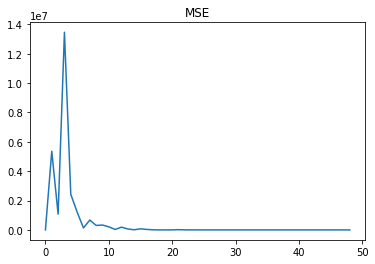

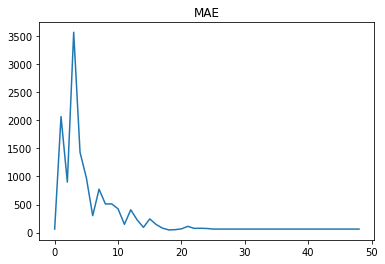

In [27]:
#plot train losses
mse_loss = [float(x) for x in train_loss['MSE']]
mae_loss = [float(x) for x in train_loss['MAE']]

plt.plot(range(len(mse_loss)), mse_loss, label='MSE')
plt.title('MSE')
plt.show()

plt.plot(range(len(mae_loss)), mae_loss, label='MAE')
plt.title('MAE')
plt.show()